In [1]:
import numpy as np
from tqdm import tqdm, trange
from brian2 import *
import matplotlib.pyplot as plt
from sheet_attractor import simulator
from util import *
from fit import *

FIG_PATH = 'figures/'
os.makedirs(FIG_PATH, exist_ok=True)


INFO       Cache size for target 'cython': 1194 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/pajucg/.cython/brian_extensions' directory. [brian2]


In [7]:
F = 1/3
_WEIGHT_MATRIX_SYMMETRY = np.array([
    [F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F],
    [F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, F, F, 0, 0, F, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, F, F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, F, 0, 0, F, F, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F, F, F],
    [F, F, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, F]
], dtype=np.float32)

def process_data(data):
    '''
    input: data: (16, 16, T)
    output: out: (16, 16, T)
    '''
    W = _WEIGHT_MATRIX_SYMMETRY.astype(np.float32)
    C = np.zeros((16, 18), dtype=W.dtype)
    C[np.arange(8), np.arange(8)] = 1
    C[np.arange(8, 16), np.arange(10, 18)] = 1
    L = C @ W.T @ C.T   # (16, 16)
    R = C @ W   @ C.T  # (16, 16)
    out = np.einsum('ai, ijt, jb -> abt', L, data, R, optimize=True)  # (16, 16, T) 
    return out

In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation
from IPython.display import HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

def create_3d_animation(processed_data, vmin=0, vmax=300, frame_stride=200, frame_duration=0.1, transition_duration=200):
    """
    Create an interactive 3D surface plot animation with Plotly.
    
    Parameters:
    -----------
    processed_data : numpy.ndarray
        3D array of shape (height, width, time_frames) containing neural activity data
    vmin : float, optional
        Minimum value for colorbar range (default: 0)
    vmax : float, optional
        Maximum value for colorbar range (default: 300)
    frame_stride : int, optional
        Sample every nth frame to reduce file size (default: 200)
    frame_duration : float, optional
        Duration of each frame in milliseconds (default: 0.1)
    transition_duration : int, optional
        Transition duration between frames in milliseconds (default: 200)
    
    Returns:
    --------
    plotly.graph_objects.Figure
        Interactive 3D animation figure
    """
    
    # Create interactive 3D surface plot with Plotly
    fig = go.Figure()

    # Add initial frame
    fig.add_trace(go.Surface(
        z=processed_data[:, :, 0],
        colorscale='Blues',
        cmin=vmin,
        cmax=vmax,
        showscale=True,
        colorbar=dict(title="Firing Rate [Hz]")
    ))

    # Update layout for better visualization
    fig.update_layout(
        title='Neural Activity Evolution Over Time',
        scene=dict(
            xaxis_title='X Position',
            yaxis_title='Y Position', 
            zaxis_title='Firing Rate [Hz]',
            xaxis=dict(range=[0, 16]),
            yaxis=dict(range=[0, 16]),
            zaxis=dict(range=[vmin, vmax]),
            aspectmode='cube',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=800,
        height=600
    )

    # Create frames for animation
    frames = []
    slider_steps = []

    frame_names = []
    for i in range(0, processed_data.shape[2], frame_stride):
        frame_name = f'frame_{i}'
        frame_names.append(frame_name)
        frame = go.Frame(
            data=[go.Surface(
                z=processed_data[:, :, i],
                colorscale='Blues',
                cmin=vmin,
                cmax=vmax,
                showscale=True
            )],
            name=frame_name,
            layout=go.Layout(
                title=f'Neural Activity at t = {i/10000:.2f} s'
            )
        )
        frames.append(frame)
        slider_steps.append(
            dict(
                method='animate',
                label=f'{i/10000:.2f}s',
                args=[[frame_name], dict(mode='immediate', frame=dict(duration=frame_duration, redraw=True), transition=dict(duration=transition_duration))],
            )
        )

    # Add frames to the 3D figure
    fig.frames = frames
    fig.update_layout(
        updatemenus=[
            dict(
                type="buttons",
                direction="left",
                buttons=list([
                    dict(
                        args=[None, {"frame": {"duration": frame_duration, "redraw": True},
                                    "fromcurrent": True, 
                                    "transition": {"duration": transition_duration},
                                    "mode": "immediate"}],
                        label="Play",
                        method="animate"
                    ),
                    dict(
                        args=[[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                        label="Pause",
                        method="animate"
                    )
                ]),
                pad={"r": 10, "t": 87},
                showactive=False,
                x=0.011,
                xanchor="right",
                y=0,
                yanchor="top"
            ),
        ],
        sliders=[dict(
            active=0,
            currentvalue={"prefix": "Time: "},
            steps=slider_steps
        )]
    )

    return fig



In [3]:
parameters = {
  "w_EE": 0.72,
  "w_EI": 0.143, # 0.143
  "w_IE": 0.76, # 0.74
  "w_II": 0.01, # 0.01
  "w_PP": 0.01,
  "w_EP": 0.013, # 0.012
  "w_PE": 0.71, # .709
  "sigma": 0.001,
}

events = [
        {'type': 'visual_cue_on', 'x': 2, 'y': 6, 'strength': 0.5, 'duration': 300*ms},
        {'type': 'visual_cue_off', 'duration': 300*ms},
        {'type': 'shift', 'direction': 'right', 'strength': 0.018, 'duration': 1100*ms},
        {'type': 'shift', 'direction': 'up', 'strength': 0.018, 'duration': 1100*ms},
        {'type': 'shift', 'direction': 'left', 'strength': 0.018, 'duration': 1100*ms},
        {'type': 'shift', 'direction': 'down', 'strength': 0.018, 'duration': 1100*ms},
    ]


06:33:00 : 0 min 2.9 sec -> simulation start
06:39:28 : 6 min 30.3 sec -> simulation end
50000


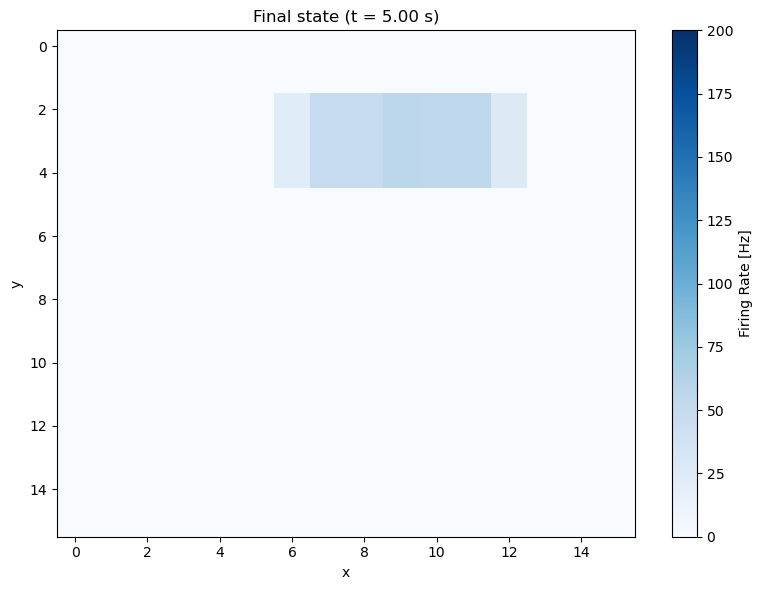

In [4]:
results = simulator(w_EE = parameters['w_EE'], # EB <-> EB
                    w_EI = parameters['w_EI'], # EPG -> R # 0.15
                    w_IE = parameters['w_IE'], # R -> EPG
                    w_II = parameters['w_II'], # R <-> R
                    w_PP = parameters['w_PP'], # PEN <-> PEN
                    w_EP = parameters['w_EP'], # EB -> PEN 
                    w_PE = parameters['w_PE'], # PEN -> EB
                    sigma = parameters['sigma'], # noise level
                    
                    events = events,
                    defaultclock_dt=0.1 # ms
                                    )
t, fr, fr_penx, fr_peny = results
print(len(t))

processed_data = process_data(fr)
# Plot the last frame
plt.figure(figsize=(8, 6))
last_frame = processed_data[:, :, -1]
im_last = plt.imshow(last_frame, cmap='Blues', aspect='auto', interpolation='none',
                     vmin=0, vmax=200)
plt.colorbar(im_last, label='Firing Rate [Hz]')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Final state (t = {(processed_data.shape[2]-1)/10000:.2f} s)')
plt.tight_layout()
plt.show()

In [8]:
# Create and show the 3D animation
processed_data = process_data(fr)
fig = create_3d_animation(processed_data)
fig.show()


In [9]:
bump_positions, fit_params = bump_position(processed_data)


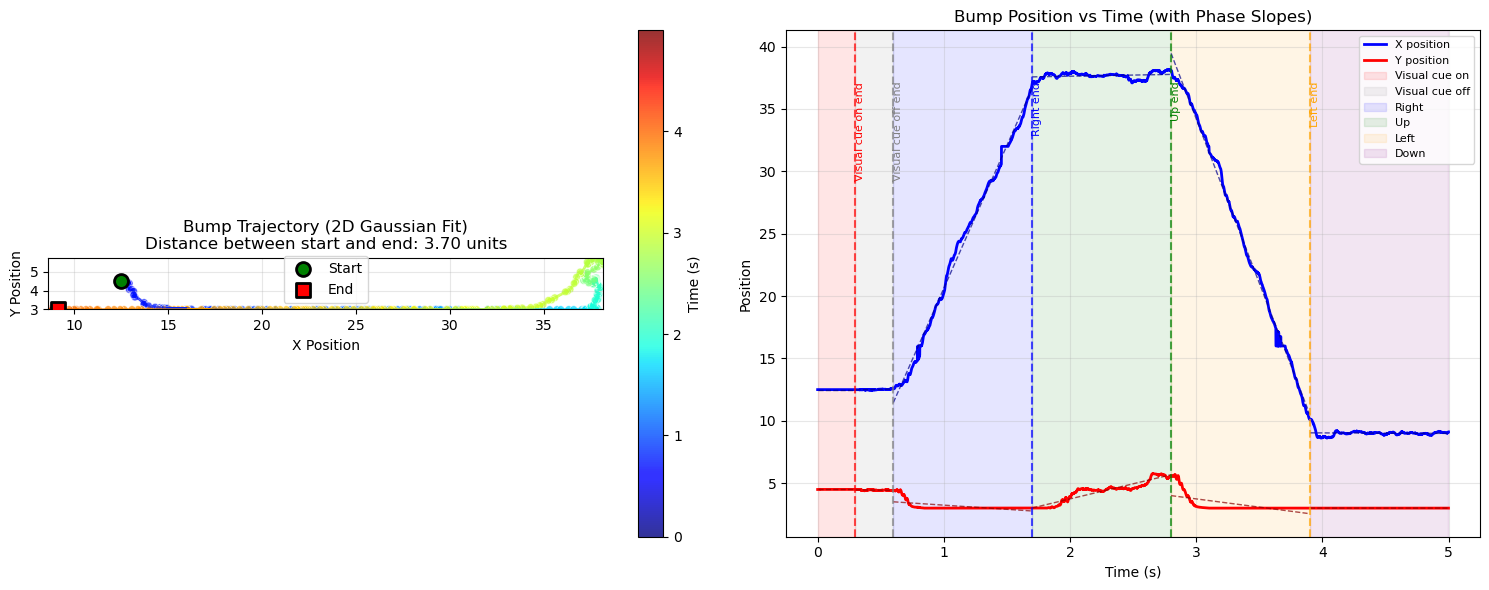

In [10]:
trajectory_results = analyze_trajectory(bump_positions, fit_params, processed_data, events)

In [22]:
print(trajectory_results['phase_results']['Right']['speed']*2*np.pi/16)

8.997389398028298
